In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("WordCoOccurrence").getOrCreate()


In [ ]:
path_to_csv_folder = "/content/drive/MyDrive/reddit-data/*"

In [ ]:
df = spark.read.format("csv").option("multiline", "true").option("quote", '"').option("header", "true").option("inferSchema", "true").option("sep", ",").option("escape", "\"").csv(path_to_csv_folder)


In [ ]:
df.show()

+----------+-------------------+----------+--------------------+---------------------------+------------------+--------------------------+-------------------+------------------+------------------+------------------+------------------+---------------------+-------+------------+--------------------+--------------------+-------+-----------+--------------+-------+--------------------+-------------------+-------------------+-------------+---------------------+---------------+-------------------+----------+---------------------+-----------------+-----------+-------------+-------------+-------------+----------------+------------+------------------------+----------+------------+---------------------+-----------+--------------------+---------------+---------+--------------+--------------+--------------+-----------------+-----------------+----------+----------------+--------------+-----------+---------+------------+------------+-----------------+-----------+---------+---------+-----------+------

In [ ]:
selected_df = df.select("subreddit", "author", "date", "post")

selected_df.show()

+----------+-------------------+----------+--------------------+
| subreddit|             author|      date|                post|
+----------+-------------------+----------+--------------------+
|depression|           peeepeed|2020/01/01|My heart aches bu...|
|depression|   cookieexpertuser|2020/01/01|Cheers I’m not su...|
|depression|         Ghostiez23|2020/01/01|Fuck titles. I’m ...|
|depression|           wisqrg50|2020/01/01|suffering from lo...|
|depression|   arizonwatermelon|2020/01/01|I can already tel...|
|depression|ThatBloodyValentine|2020/01/01|I just turned 19 ...|
|depression|     chiefkeith7511|2020/01/01|Is there any way ...|
|depression|        dustin_keel|2020/01/01|Horrid mood swing...|
|depression|         BaIA102037|2020/01/01|ANHEDONIA &amp; e...|
|depression|      bounce-bounce|2020/01/01|Empty I wanted to...|
|depression|    DrowningPilot21|2020/01/01|I'm still here Ca...|
|depression|      emogirl123456|2020/01/01|numb i’m thinking...|
|depression|          cut

In [ ]:
suicide_posts_df = selected_df.filter(selected_df["subreddit"] == "suicidewatch")


In [ ]:
suicide_posts_df.show()

+------------+--------------------+----------+--------------------+
|   subreddit|              author|      date|                post|
+------------+--------------------+----------+--------------------+
|suicidewatch|       Dancing_Angel|2020/01/01|How do you guys f...|
|suicidewatch|               wjufh|2020/01/01|i want to get hel...|
|suicidewatch|Effective-Letterhead|2020/01/01|I can’t stop myse...|
|suicidewatch|    iamdougiescoffee|2020/01/01|There's no point ...|
|suicidewatch|           ewwwyucky|2020/01/01|My friends keep f...|
|suicidewatch|   notreallymetoday1|2020/01/01|So tired. Throwaw...|
|suicidewatch| FrightenedMussolini|2020/01/01|I think my mom mi...|
|suicidewatch|       justsomestone|2020/01/01|what to do? Hi,I ...|
|suicidewatch|     alt_account1122|2020/01/01|I really wasn’t s...|
|suicidewatch|       beanacomputer|2020/01/01|I think I'm going...|
|suicidewatch|           jesse1300|2020/01/01|Let me die I wish...|
|suicidewatch|throwmyselfoffbridge|2020/01/01|it

In [ ]:
suicide_posts_df_pandas = suicide_posts_df.toPandas()

In [ ]:
suicide_posts_df_pandas.to_csv("/content/suicide_posts_pd.csv")

In [ ]:
#suicide_posts_df=suicide_posts_df.drop("words")

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col, lower, regexp_replace, explode, array_contains

In [ ]:
suicide_posts_df = suicide_posts_df.withColumn("post", lower(col("post")))
suicide_posts_df = suicide_posts_df.withColumn("post", regexp_replace(col("post"), "[^a-zA-Z\\s]", ""))

In [ ]:
tokenizer = Tokenizer(inputCol="post", outputCol="words")
suicide_posts_df = tokenizer.transform(suicide_posts_df)

In [ ]:

default_stopwords = StopWordsRemover.loadDefaultStopWords("english")

In [ ]:
custom_stopwords = [
    "im","ive", "you","we", "they", "he", "she", "it’s", "dont", "cant", "didnt", "wont", "isnt", "arent",
    "get", "know", "want", "like", "feel", "have", "be", "do", "did", "does", "doing", "am", "are", "is", "been", "being",
    "really", "just", "so", "well", "very", "too", "much", "such", "thing", "things", "lot", "kind", "sort", "type", "bit",
    "actually", "basically", "probably", "possibly", "literally", "everybody", "nobody", "someone",
    "everything", "nothing", "anything", "whatever", "whenever", "wherever", "however","","=","think","even","something","kill","today","thought",
    "going","go","said","still","life","one","told","alway","feels","always","never","time"
]

In [ ]:
all_stopwords = default_stopwords + custom_stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=all_stopwords)
suicide_posts_df = stopwords_remover.transform(suicide_posts_df)

In [ ]:

help_df = suicide_posts_df.filter(array_contains(col("filtered_words"), "help"))


In [ ]:
suicide_posts_df.show()

+------------+--------------------+----------+--------------------+--------------------+--------------------+
|   subreddit|              author|      date|                post|               words|      filtered_words|
+------------+--------------------+----------+--------------------+--------------------+--------------------+
|suicidewatch|       Dancing_Angel|2020/01/01|how do you guys f...|[how, do, you, gu...|[guys, less, dead...|
|suicidewatch|               wjufh|2020/01/01|i want to get hel...|[i, want, to, get...|[help, parents, s...|
|suicidewatch|Effective-Letterhead|2020/01/01|i cant stop mysel...|[i, cant, stop, m...|[stop, loving, fi...|
|suicidewatch|    iamdougiescoffee|2020/01/01|theres no point i...|[theres, no, poin...|[theres, point, c...|
|suicidewatch|           ewwwyucky|2020/01/01|my friends keep f...|[my, friends, kee...|[friends, keep, f...|
|suicidewatch|   notreallymetoday1|2020/01/01|so tired throwawa...|[so, tired, throw...|[tired, throwaway...|
|suicidewa

In [ ]:
word_frequencies = help_df.withColumn("word", explode(col("filtered_words")))
word_frequencies = word_frequencies.filter(word_frequencies.word != "help")
word_frequencies = word_frequencies.groupBy("word").count().orderBy("count", ascending=False)

word_frequencies.show()


+-------+-----+
|   word|count|
+-------+-----+
| people|13253|
|friends| 8793|
|  years| 8602|
|   need| 7408|
|anymore| 7407|
|    day| 7127|
| family| 7070|
|suicide| 6902|
|    way| 6683|
|   make| 6534|
|    got| 6317|
|   back| 6287|
| better| 6245|
|    end| 6098|
|    die| 6058|
|   live| 5965|
|    see| 5964|
|   good| 5925|
| school| 5861|
|  every| 5853|
+-------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

In [ ]:
window_spec = Window.orderBy(word_frequencies['count'].desc())
sorted_word_frequencies = word_frequencies.withColumn('rank', rank().over(window_spec))

top_words = sorted_word_frequencies.filter(sorted_word_frequencies['rank'] <= 20)
bottom_words = sorted_word_frequencies.filter(sorted_word_frequencies['rank'] > (sorted_word_frequencies.count() - 20))

top_words_pd = top_words.toPandas()


In [ ]:
top_words_pd.to_csv("/content/top_words_pd.csv")

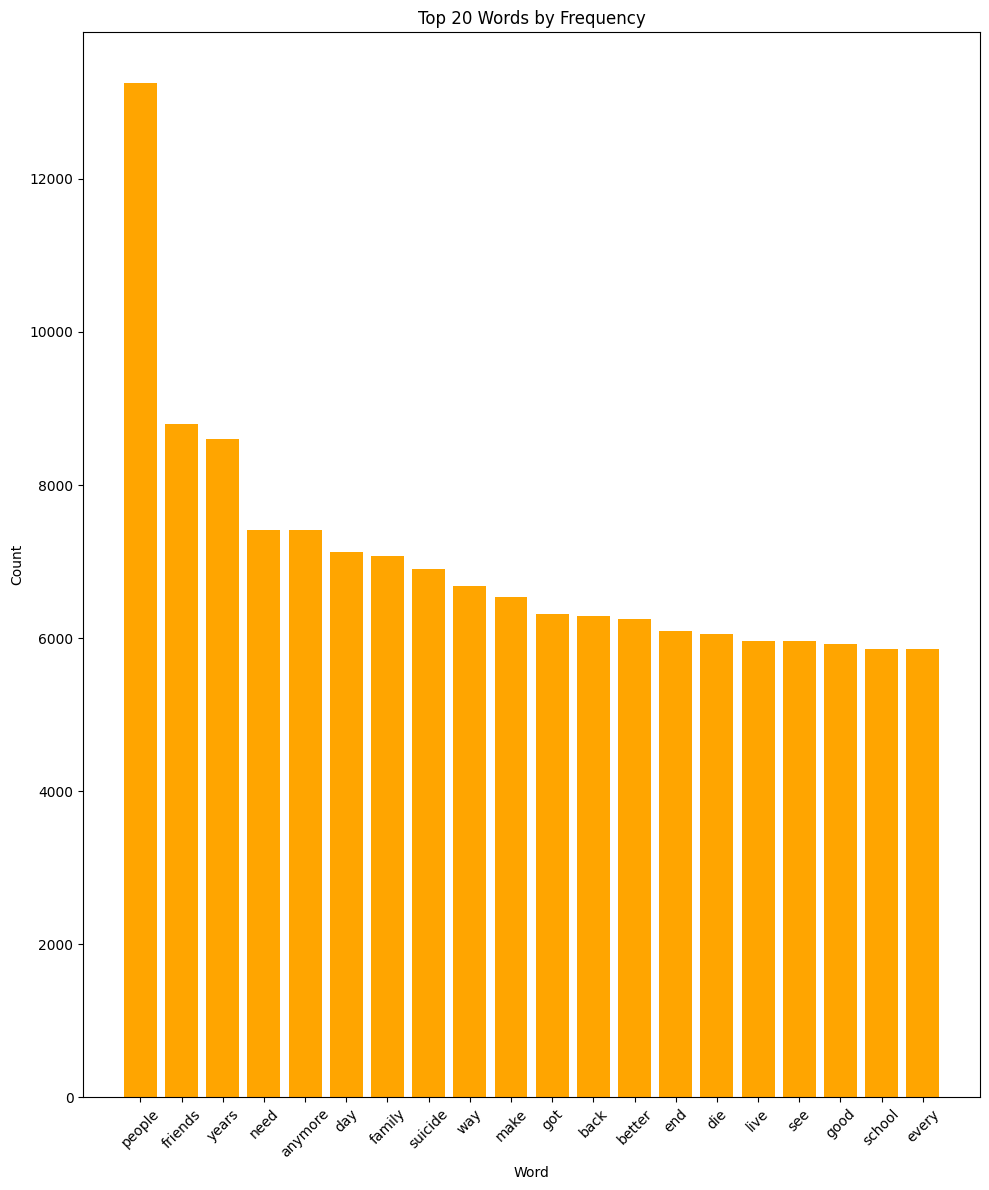

In [ ]:

import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots(1, figsize=(10, 12))

ax1.bar(top_words_pd['word'], top_words_pd['count'], color='orange')
ax1.set_xlabel('Word')
ax1.set_ylabel('Count')
ax1.set_title('Top 20 Words by Frequency')
ax1.tick_params(axis='x', rotation=45)


plt.tight_layout()

plt.show()


In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.clustering import LDA, LDAModel
from pyspark.sql import SparkSession

In [ ]:
cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")
model = cv.fit(suicide_posts_df)
result = model.transform(suicide_posts_df)
idf_model = idf.fit(result)
result = idf_model.transform(result)

In [ ]:
result.show()

+------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   subreddit|              author|      date|                post|               words|      filtered_words|        raw_features|            features|
+------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|suicidewatch|       Dancing_Angel|2020/01/01|how do you guys f...|[how, do, you, gu...|[guys, less, dead...|(67372,[0,1,12,14...|(67372,[0,1,12,14...|
|suicidewatch|               wjufh|2020/01/01|i want to get hel...|[i, want, to, get...|[help, parents, s...|(67372,[2,12,28,3...|(67372,[2,12,28,3...|
|suicidewatch|Effective-Letterhead|2020/01/01|i cant stop mysel...|[i, cant, stop, m...|[stop, loving, fi...|(67372,[0,1,5,6,1...|(67372,[0,1,5,6,1...|
|suicidewatch|    iamdougiescoffee|2020/01/01|theres no point i...|[theres, no, poin...|

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
kmeans = BisectingKMeans(k=5, seed=1)
model = kmeans.fit(result)

In [ ]:
model.save("/content/model")


In [ ]:
clustered_posts = model.transform(result)


In [ ]:
clustered_posts.show()

+------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   subreddit|              author|      date|                post|               words|      filtered_words|        raw_features|            features|prediction|
+------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|suicidewatch|       Dancing_Angel|2020/01/01|how do you guys f...|[how, do, you, gu...|[guys, less, dead...|(67372,[0,1,12,14...|(67372,[0,1,12,14...|         2|
|suicidewatch|               wjufh|2020/01/01|i want to get hel...|[i, want, to, get...|[help, parents, s...|(67372,[2,12,28,3...|(67372,[2,12,28,3...|         1|
|suicidewatch|Effective-Letterhead|2020/01/01|i cant stop mysel...|[i, cant, stop, m...|[stop, loving, fi...|(67372,[0,1,5,6,1...|(67372,[0,1,5,6,1...|         2|
|suicidewatch|    iamd

In [ ]:
clustered_posts.select("filtered_words", "prediction").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, concat_ws
from wordcloud import WordCloud
import pyspark.sql.functions as F

In [ ]:
# Group the data by cluster and concatenate text within each cluster
'''clustered_text = clustered_posts.groupBy("prediction") \
    .agg(F.collect_list("filtered_words").alias("Text"))'''
clustered_text = clustered_posts.groupBy("prediction") \
    .agg(concat_ws(" ", flatten(F.collect_list("filtered_words"))).alias("Text"))


In [ ]:
clustered_text.show()

+----------+--------------------+
|prediction|                Text|
+----------+--------------------+
|         1|help parents say ...|
|         3|tired throwaway a...|
|         4|friend doesnt liv...|
|         2|guys less dead in...|
|         0|hii anyone read w...|
+----------+--------------------+



In [ ]:
from pyspark.sql.functions import concat_ws, flatten


In [ ]:
#clustered_text = clustered_text.withColumn("Text", concat_ws(" ", flatten("Text")))


In [ ]:
clustered_text.show()

+----------+--------------------+
|prediction|                Text|
+----------+--------------------+
|         1|think mom might c...|
|         3|trans good world ...|
|         4|friend told doesn...|
|         2|guys less dead in...|
|         0|help parents say ...|
+----------+--------------------+



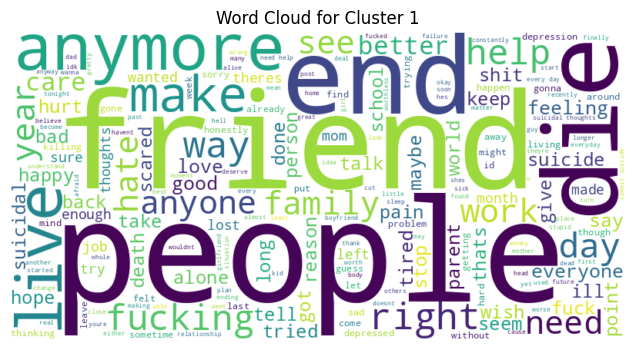

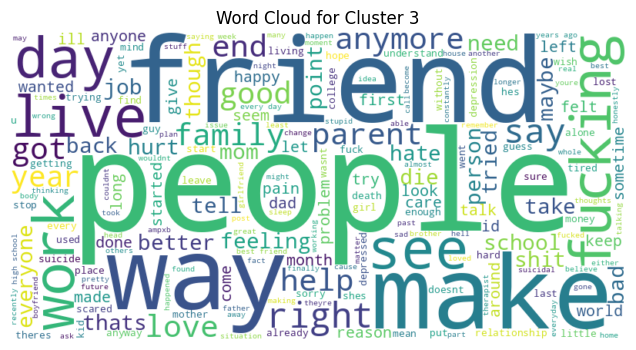

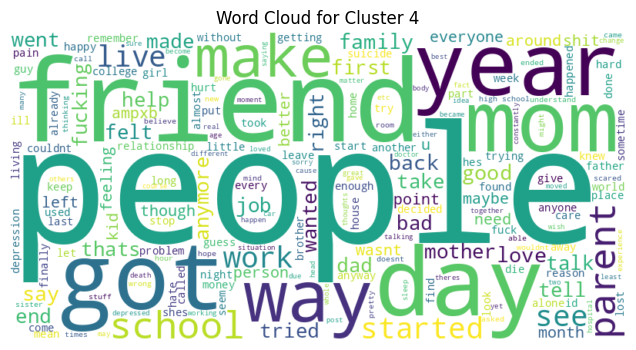

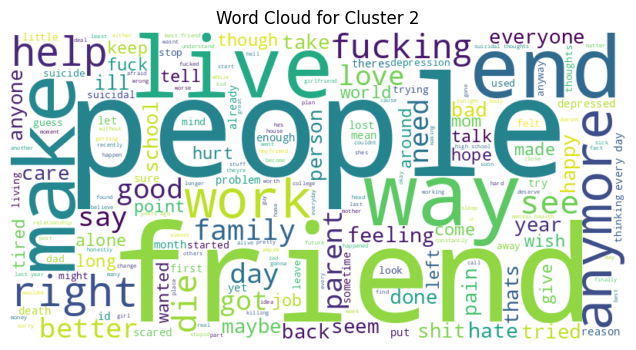

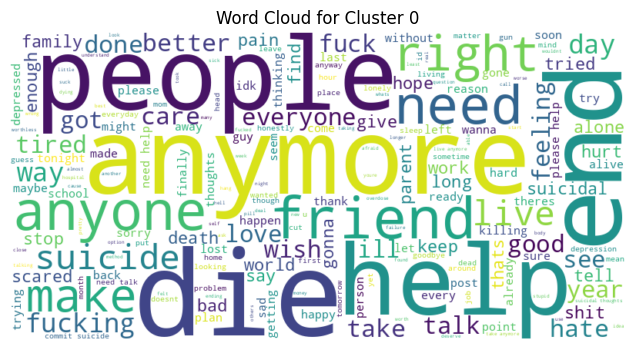

In [ ]:
for row in clustered_text.collect():
  cluster = row['prediction']
  text = row['Text']
 #Wordcloud Cluster
  wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

  # Display the word cloud
  plt.figure(figsize=(8, 4))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Word Cloud for Cluster {cluster}")
  plt.show()


In [ ]:
import plotly.express as px


In [ ]:
#have to save clustered_text as csv and parquet